In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow import keras
from PIL import Image

In [214]:
path = os.path.join("C:\\Users\\Robin\\Desktop\\deep_learning\\MineRLNavigateDense-v0\\v3_absolute_grape_changeling-12_2293-4124")

def process_frames():
    vid = np.load(path+"\\NDTRAIN.npy", allow_pickle=True)
    print(vid[0].shape)
    number_of_frames = vid[0].shape[0]/12288
    vid_imgs = vid[0].reshape([int(number_of_frames), 64, 64, 3])
    vid_imgs = np.array(vid_imgs[-1794:][:]).astype(np.uint8)
    print(vid_imgs.shape)
    processed = vid_imgs.reshape(1794, 64, 64, 3)
    processed = processed[:-1]
    test = processed[-1]

    test = test.reshape(-1,64,64,3)
    
    return test, processed

process_frames()

(22511616,)
(1794, 64, 64, 3)


(array([[[[ 12,  23,  12],
          [ 20,  31,  20],
          [ 21,  29,  19],
          ...,
          [ 20,  31,  20],
          [ 20,  31,  20],
          [ 17,  28,  17]],
 
         [[ 18,  29,  18],
          [ 13,  24,  13],
          [ 19,  27,  17],
          ...,
          [ 16,  27,  16],
          [ 19,  30,  19],
          [  9,  20,   9]],
 
         [[ 20,  31,  20],
          [ 16,  27,  16],
          [ 14,  22,  12],
          ...,
          [ 17,  28,  17],
          [ 18,  29,  16],
          [ 20,  31,  18]],
 
         ...,
 
         [[ 79,  56,  41],
          [ 79,  56,  41],
          [ 78,  56,  38],
          ...,
          [110,  77,  52],
          [161, 122,  92],
          [137,  98,  68]],
 
         [[ 79,  57,  39],
          [ 78,  56,  38],
          [ 75,  54,  39],
          ...,
          [107,  78,  56],
          [120,  75,  40],
          [167, 122,  87]],
 
         [[ 78,  56,  38],
          [ 77,  55,  37],
          [ 75,  54,  39],
   

In [215]:
data = np.load(path+"\\rendered.npz")

print("available data keys: \n")
for x in data.keys():
    print(x)
print("\n")

def state_observations():
    state_obs = [data[x] for x in data.keys()]
    state_obs[1] = state_obs[1][:1792]
    state_obs[2] = state_obs[2][:1792]
    camera_x = np.array([x[0] for x in state_obs[11]])/180.
    camera_y = np.array([x[1] for x in state_obs[11]])/180.
    place = state_obs[-1]
    state_obs = state_obs[:11]
    state_obs.append(camera_x)
    state_obs.append(camera_y)
    state_obs.append(place)
    state_obs = state_obs[3:]
    
    for i in range(len(state_obs[-1])):
        if state_obs[-1][i] == "none":
            state_obs[-1][i] = 0
        else:
            state_obs[-1][i] = 1
    
    actions = []
    for i in range(1792):
        action_cluster = []
        for x in range(11):
            action_cluster.append(state_obs[x][i])
        actions.append(action_cluster)
        
    print(np.array(actions).shape)
    
    return actions

actions = np.array(state_observations()).astype(np.float32)
print(actions)

available data keys: 

reward
observation$compassAngle
observation$inventory$dirt
action$forward
action$left
action$back
action$right
action$jump
action$sneak
action$sprint
action$attack
action$camera
action$place


(1792, 11)
[[ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.          0.          0.         ... -0.          0.00166668
   0.        ]
 [ 1.          0.          0.         ... -0.00166666  0.00499997
   0.        ]
 ...
 [ 1.          1.          0.         ...  0.          0.
   0.        ]
 [ 1.          0.          0.         ...  0.          0.
   0.        ]
 [ 1.          0.          0.         ...  0.          0.
   0.        ]]


In [220]:
action_model = keras.models.Sequential([
    keras.layers.Conv2D(64, kernel_size=5, input_shape=[64, 64, 2]),
    keras.layers.Conv2D(32, kernel_size=3),
    keras.layers.Flatten(),
    keras.layers.Dense(11, activation="sigmoid")
])

action_model.compile(loss="binary_crossentropy", optimizer="Adam")

In [221]:
batch_size = 1

def train_model(model, n_epochs=10):
    for epoch in range(n_epochs):
        
        print(epoch)
        batch = np.random.choice(1792, batch_size)
        
        print("SHAPE",process_frames()[1].shape)
        img_a = np.array(Image.fromarray(process_frames()[1][batch].reshape(64,64,3), "RGB").convert("L"))
        print(img_a)
        img_b = np.array(Image.fromarray(process_frames()[1][batch+1].reshape(64,64,3), "RGB").convert("L"))
        stacked = np.stack([img_a, img_b], axis=2).reshape(1, 64, 64, 2)
      
        
        model.train_on_batch(stacked, tf.cast(np.array(actions)[batch], tf.float32))
        
train_model(action_model)

0
(22511616,)
(1794, 64, 64, 3)
SHAPE (1793, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
[[ 18  18  18 ...  21  28  22]
 [ 16  18  19 ...  28  31  12]
 [  6  17  18 ...  25  25  26]
 ...
 [106  87  88 ...  71  50  67]
 [107  88  87 ...  51  70  68]
 [ 88  88  99 ...  52  51  88]]
(22511616,)
(1794, 64, 64, 3)
1
(22511616,)
(1794, 64, 64, 3)
SHAPE (1793, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
[[61 72 74 ... 55 69 69]
 [45 60 71 ... 55 55 55]
 [45 45 60 ... 68 55 55]
 ...
 [42 89 78 ... 84 85 79]
 [40 79 79 ... 82 66 80]
 [79 79 72 ... 68 82 82]]
(22511616,)
(1794, 64, 64, 3)
2
(22511616,)
(1794, 64, 64, 3)
SHAPE (1793, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
[[33  2  1 ...  0  1 32]
 [30 37  1 ... 12 16 16]
 [29 28 36 ... 16 16 16]
 ...
 [ 2  2 51 ... 72 89 98]
 [ 2 50  2 ... 74 87 88]
 [ 1 49 47 ... 73 74 75]]
(22511616,)
(1794, 64, 64, 3)
3
(22511616,)
(1794, 64, 64, 3)
SHAPE (1793, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
[[179 178 178 ...  21   9   8]
 [179 179 179 ...  18  24  11]


(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)
(22511616,)
(1794, 64, 64, 3)


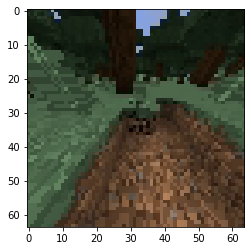

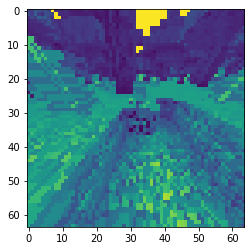

(22511616,)
(1794, 64, 64, 3)


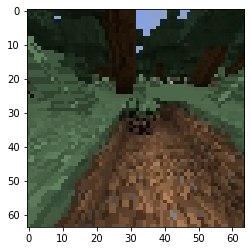

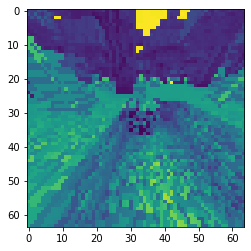

[[0.0000000e+00 0.0000000e+00 0.0000000e+00 1.6507775e-17 0.0000000e+00
  7.4284667e-01 1.0000000e+00 1.0000000e+00 2.4224406e-33 1.0000000e+00
  2.6739041e-15]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]


In [222]:
random_index = np.random.choice(1792)
test_a = Image.fromarray(process_frames()[1][random_index], "RGB").convert("L")
test_b = Image.fromarray(process_frames()[1][random_index+1], "RGB").convert("L")

plt.imshow(process_frames()[1][random_index])
plt.show()

plt.imshow(test_a)
plt.show()

plt.imshow(process_frames()[1][random_index+1])
plt.show()

plt.imshow(test_b)
plt.show()

stacked = np.stack([test_a, test_b])

print(action_model.predict(stacked.reshape(1,64,64,2)))
print(np.array(actions)[random_index])